## 4.0 CNN Genre Classification

This notebook continues with supervised learning using the generated spectorgrams to do genre classification and prediction, but now with transfer learning utilizing pre-trained models.

### Table of Contents
[4.1. Setup](#1.)<br>
[4.1.1 Loading libraries](#1.1)<br>
[4.1.2 Setting data directories](#1.2)<br>
[4.1.3 Defining functions](#1.3)<br>
[4.1.4 Reading in train, validation, and test data sets](#1.4)<br>

[4.2. Transfer Learning with Pre-Trained VGG16](#2.)<br>
[4.2.1 VGG16 setup](#2.1)<br>
[4.2.2 VGG16 - 1st Attempt](#2.2)<br>
[4.2.3 VGG16 - 2nd Attempt](#2.3)<br>


### 4.1. Setup <a class="anchor" id="1."></a>

#### 4.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
import datetime

from sklearn import preprocessing

#### 4.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
ds_description = '5x10s'
# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

Directory of spectrograms: ./data/spect_subsample_5x10s_np


In [3]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental'}

#### 4.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [4]:
def load_data(data_dir, ds_description, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description}_np.npy')

    train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
    val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
    test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

#### 4.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [5]:
# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, 'X', 'Y')

Loading .npy data files...

Total processing time (h:mm:ss): 0:00:41

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (31970, 431, 128)
Shape of 'train_Y': (31970, 8)
Shape of 'val_X': (4000, 431, 128)
Shape of 'val_Y': (4000, 8)
Shape of 'test_X': (4000, 431, 128)
Shape of 'test_Y': (4000, 8)


### 4.2. Transfer Learning with Pre-Trained VGG16 <a class="anchor" id="2."></a>

#### 4.2.1 CNN setup <a class="anchor" id="2.1"></a>

In [63]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Bidirectional, CuDNNLSTM, Dropout, Activation, CuDNNGRU
from keras.layers import Conv1D, Conv2D, concatenate, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers

from os.path import isfile

from keras import applications

In [66]:
def show_summary_stats(history, model_name):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### 4.2.2 VGG16 - 1st Attempt <a class="anchor" id="2.2"></a>

Utilizing Oxford VGG16 CNN model which is pre-trained on ImageNet data.  However, because VGG16 has its weights trained on 3 channel input (RGB), we would have to extract out the learned weights and for the first layer, we had to do a weighted sum of the 3 channels to a single channel to be able to take in the input of the mel spectrograms.

We re-built the CNN in accordance to the VGG16 architecture and loaded in the pre-trained weights, and tried a variety of combinations for the setting the bottom layers to be untrainable as those had alrady learned low level image recognition features.

https://github.com/RohitSaha/VGG_Imagenet_Weights_GrayScale_Images/blob/master/convert_vgg_grayscale.py

For the first attempt, we set the number of non-trainable layers to be the first 7 layers, which corresponds to the bottom 2 blocks of Conv2D layers, total 4 layers.  We also increased the first dense layer to 256 nodes.

We found that the Adam optimizer was not getting any sort of meaningful convergence in accuracy with the results stagnant at 0.125, and opted to switch to SGD with a small learning rate of 0.001.



In [64]:
model_name = 'vgg16_1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'padding' : 'same',
      'activation' : 'relu',
#      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : 'adam',
      'dense1' : 256,
      'dense2' : 16,
      'dropout1' : 0.2
     }
num_classes = len(genre_dict)

train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
# For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
# RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

# getting weights of block1 conv1.
block1_conv1 = vgg_model.get_layer('block1_conv1').get_weights()
weights, biases = block1_conv1

# :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
# convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
weights = np.transpose(weights, (3, 2, 0, 1))


kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

# Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

# iterate out_channels number of times
for i in range(kernel_out_channels):

	# get kernel for every out_channel
	get_kernel = weights[i, :, :, :]

	temp_kernel = np.zeros((3, 3))

	# :get_kernel shape = [3, 3, 3]
	# axis, dims = (0, in_channel), (1, row), (2, col)

	# calculate weighted average across channel axis
	in_channels, in_rows, in_columns = get_kernel.shape

	for in_row in range(in_rows):
		for in_col in range(in_columns):
			feature_red = get_kernel[0, in_row, in_col]
			feature_green = get_kernel[1, in_row, in_col]
			feature_blue = get_kernel[2, in_row, in_col]

			# weighted average for RGB filter
			total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

			temp_kernel[in_row, in_col] = total


	# :temp_kernel is a 3x3 matrix [rows x columns]
	# add an axis at the end to specify in_channel as 1

	# 2 ways of doing this,

	# First: Add axis directly at the end of :temp_kernel to make its shape: [3, 3, 1], but this might be 
	# an issue when concatenating all feature maps

	# Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
	temp_kernel = np.expand_dims(temp_kernel, axis=0)

	# Now, :temp_kernel shape is [1, 3, 3]

	# Concat :temp_kernel to :grayscale_weights along axis=0
	grayscale_weights[i, :, :, :] = temp_kernel

# Dimension of :grayscale_weights is [64, 1, 3, 3]
# In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

# dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
# tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

# Go from (0, 1, 2, 3) to (2, 3, 1, 0)
grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

# combine :grayscale_weights and :biases
new_block1_conv1 = [grayscale_weights, biases]


# Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

# get weights of all the layers starting from 'block1_conv2'
vgg16_weights = {}
for layer in vgg_model.layers[2:]:
	if "conv" in layer.name:
		vgg16_weights["spect_" + layer.name] = vgg_model.get_layer(layer.name).get_weights()

del vgg_model


# Custom build VGG16
input = Input(shape=(train_X1.shape[1:]), name='spect_input')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(train_X1.shape[1:]), 
           data_format="channels_last", name='spect_block1_conv1')(input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='spect_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv3')(x)
x = MaxPooling2D((8, 8), strides=(8, 8), name='spect_block5_pool')(x)

model = Model(inputs=input, outputs=x)

model.get_layer('spect_block1_conv1').set_weights(new_block1_conv1)
for layer in model.layers[2:]:
	if 'conv' in layer.name:
		model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

# model.save('vgg_grayscale_spect.hdf5')

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'])(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'])(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:9]:
    layer.trainable = False
    

# Complie the model

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_1


C:\Users\kw.UNLOVEDPC\Anaconda3\envs\py3gpu-Env\lib\site-packages\ipykernel_launcher.py:160: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("sp..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spect_input (InputLayer)     (None, 431, 128, 1)       0         
_________________________________________________________________
spect_block1_conv1 (Conv2D)  (None, 431, 128, 64)      640       
_________________________________________________________________
spect_block1_conv2 (Conv2D)  (None, 431, 128, 64)      36928     
_________________________________________________________________
spect_block1_pool (MaxPoolin (None, 215, 64, 64)       0         
_________________________________________________________________
spect_block2_conv1 (Conv2D)  (None, 215, 64, 128)      73856     
_________________________________________________________________
spect_block2_conv2 (Conv2D)  (None, 215, 64, 128)      147584    
_________________________________________________________________
spect_block2_pool (MaxPoolin (None, 107, 32, 128)      0         
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


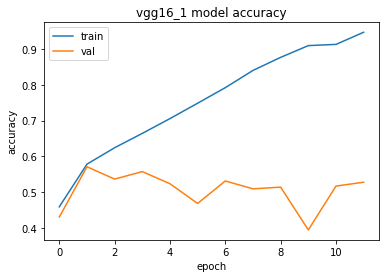

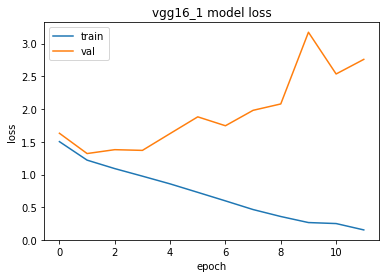

In [67]:
show_summary_stats(history, model_name)

In [ ]:
Seems to be overfitting from the start, and the increasing cross-entropy loss 

#### 4.2.3 VGG16 - 2nd Attempt <a class="anchor" id="2.3"></a>

Due to overfitting from the 1st attempt, we tried to increase the non-trainable layers so that only the last block of 3 Conv2D layers have trainbale parameters.  We also added L2 regularization to the dense layers, decreased the number of nodes in the first dense fully connected layer from 256 to 64 and increased dropout to 50%.

There was still observed overfitting and accuracy was 0.565.

In [75]:
model_name = 'vgg16_2'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'non-trained_layers': 15,
      'padding' : 'same',
      'activation' : 'relu',
      'l2' : 0.01,
      'epochs' : 12,
#      'optimizer' : SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
      'dense1' : 64,
      'dense2' : 16,
      'dropout1' : 0.5
     }
num_classes = len(genre_dict)

train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

keras.backend.clear_session()

# Instantiate the pre-trained VGG16 model without the top dense layer
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
# For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
# RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

# getting weights of block1 conv1.
block1_conv1 = vgg_model.get_layer('block1_conv1').get_weights()
weights, biases = block1_conv1

# :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
# convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
weights = np.transpose(weights, (3, 2, 0, 1))


kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

# Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

# iterate out_channels number of times
for i in range(kernel_out_channels):

	# get kernel for every out_channel
	get_kernel = weights[i, :, :, :]

	temp_kernel = np.zeros((3, 3))

	# :get_kernel shape = [3, 3, 3]
	# axis, dims = (0, in_channel), (1, row), (2, col)

	# calculate weighted average across channel axis
	in_channels, in_rows, in_columns = get_kernel.shape

	for in_row in range(in_rows):
		for in_col in range(in_columns):
			feature_red = get_kernel[0, in_row, in_col]
			feature_green = get_kernel[1, in_row, in_col]
			feature_blue = get_kernel[2, in_row, in_col]

			# weighted average for RGB filter
			total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

			temp_kernel[in_row, in_col] = total


	# :temp_kernel is a 3x3 matrix [rows x columns]
	# add an axis at the end to specify in_channel as 1

	# 2 ways of doing this,

	# First: Add axis directly at the end of :temp_kernel to make its shape: [3, 3, 1], but this might be 
	# an issue when concatenating all feature maps

	# Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
	temp_kernel = np.expand_dims(temp_kernel, axis=0)

	# Now, :temp_kernel shape is [1, 3, 3]

	# Concat :temp_kernel to :grayscale_weights along axis=0
	grayscale_weights[i, :, :, :] = temp_kernel

# Dimension of :grayscale_weights is [64, 1, 3, 3]
# In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

# dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
# tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

# Go from (0, 1, 2, 3) to (2, 3, 1, 0)
grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

# combine :grayscale_weights and :biases
new_block1_conv1 = [grayscale_weights, biases]


# Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

# get weights of all the layers starting from 'block1_conv2'
vgg16_weights = {}
for layer in vgg_model.layers[2:]:
	if "conv" in layer.name:
		vgg16_weights["spect_" + layer.name] = vgg_model.get_layer(layer.name).get_weights()

del vgg_model


# Custom build VGG16
input = Input(shape=(train_X1.shape[1:]), name='spect_input')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(train_X1.shape[1:]), 
           data_format="channels_last", name='spect_block1_conv1')(input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='spect_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='spect_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='spect_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='spect_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='spect_block5_conv3')(x)
x = MaxPooling2D((8, 8), strides=(8, 8), name='spect_block5_pool')(x)

model = Model(inputs=input, outputs=x)

model.get_layer('spect_block1_conv1').set_weights(new_block1_conv1)
for layer in model.layers[2:]:
	if 'conv' in layer.name:
		model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

# model.save('vgg_grayscale_spect.hdf5')

# Getting output tensor of the last VGG layer that we want to include
fc = model.layers[-1].output
# Define new dense layers
fc = Flatten()(fc)
fc = Dense(hp['dense1'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dropout(hp['dropout1'])(fc)
fc = Dense(hp['dense2'], activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']))(fc)
fc = Dense(num_classes, activation='softmax')(fc)

# Creating new model
model = Model(input=model.input, output=fc)

# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:hp['non-trained_layers']]:
    layer.trainable = False
    

# Complie the model
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
            loss='categorical_crossentropy',
            optimizer=sgd,
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Directory of model parameters to be saved: ./models/vgg16_2


C:\Users\kw.UNLOVEDPC\Anaconda3\envs\py3gpu-Env\lib\site-packages\ipykernel_launcher.py:163: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("sp..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spect_input (InputLayer)     (None, 431, 128, 1)       0         
_________________________________________________________________
spect_block1_conv1 (Conv2D)  (None, 431, 128, 64)      640       
_________________________________________________________________
spect_block1_conv2 (Conv2D)  (None, 431, 128, 64)      36928     
_________________________________________________________________
spect_block1_pool (MaxPoolin (None, 215, 64, 64)       0         
_________________________________________________________________
spect_block2_conv1 (Conv2D)  (None, 215, 64, 128)      73856     
_________________________________________________________________
spect_block2_conv2 (Conv2D)  (None, 215, 64, 128)      147584    
_________________________________________________________________
spect_block2_pool (MaxPoolin (None, 107, 32, 128)      0         
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


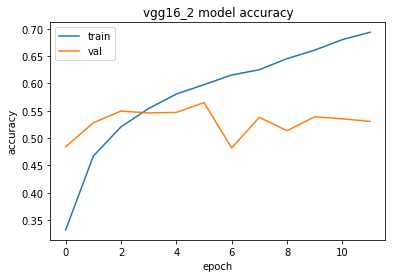

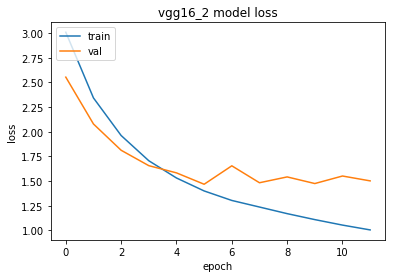

In [76]:
show_summary_stats(history, model_name)